In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from adjustText import adjust_text
import pandas as pd
from scipy.stats import pearsonr, spearmanr, kendalltau
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.ticker import ScalarFormatter
import sys
sys.path.insert(1,'../CompareNormalisation')
from Functions import *
import MetricMapping
from matplotlib import gridspec

# Access the mappings:
type_mapping = MetricMapping.type_mapping
name_mapping = MetricMapping.name_mapping

In [2]:
transformed_minmax_scaled = pd.read_csv("../Data/NotScaled_AllRes.csv")

for res in ['_5m', '_10m', '_30m', '_60m']:

    transformed_minmax_scaled[f'peak_mean_ratio{res}'] = transformed_minmax_scaled[f'peak_mean_ratio_scaled{res}']
    transformed_minmax_scaled[f'relative_amp{res}'] = transformed_minmax_scaled[f'relative_amp_scaled{res}']
    del transformed_minmax_scaled[f'relative_amp_scaled{res}']
    del transformed_minmax_scaled[f'peak_mean_ratio_scaled{res}']

column_names = transformed_minmax_scaled.columns.str.replace('_log', '')
column_names = column_names.str.replace('_yj', '')
# column_names = column_names.str.replace('_wi', '')
transformed_minmax_scaled.columns = column_names

In [3]:
cols_to_delete = [f'{var}_{res}'
    for var in ['total_precip', 'duration', 'event_num']
    for res in ['5m', '10m', '30m', '60m']]

transformed_minmax_scaled.drop(columns=cols_to_delete, inplace=True)

In [4]:
metrics = set()
for col in transformed_minmax_scaled.columns:
    metric, res = split_metric_resolution(col)
    if res is not None:
        metrics.add(metric)
metrics = list(metrics)

metrics.remove('T50')
metrics.remove('BSC_Index')

categorical_metrics = ['3rd_ARR',  '3rd_rcg',  '3rd_w_peak', '4th_w_peak', '5th_w_peak', 'third_ppr', '3rd_w_most', 
                       '4th_w_most', '5th_w_most']
continuous_metrics = [metric for metric in metrics if metric not in categorical_metrics]

In [5]:
summary_df = compute_metric_sensitivity_by_resolution(df=transformed_minmax_scaled,
    continuous_metrics=continuous_metrics,
    categorical_metrics=categorical_metrics,
    resolutions=["10m", "30m", "60m"])

summary_df["type2"] = summary_df["metric"].map(type_mapping)

# Sort by type_2 and descending rank_corr
summary_df = summary_df.sort_values(
    by=["type2", "rank_corr"],
    key=lambda col: (
        col.map({'Asymmetry': 0, 'Peakiness': 1, 'Concentration': 2, 'Intermittency': 3})
        if col.name == "type2" else -col))

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [6]:
# Split intermittency and other types
df_intermittency = summary_df[summary_df["type2"] == "Intermittency"]
df_other = summary_df[(summary_df["type2"] != "Intermittency") & (summary_df["type"] != "categorical")]
df_categorical = summary_df[summary_df["type"] == "categorical"]

In [18]:
def plot_histograms(ax, transformed_minmax_scaled, metric, metric_type_df, log_scale_metrics, type_color_map, resolutions):
    label_resolutions=['5 minute', "10 minute", "30 minute", "60 minute"]
    for num, res in enumerate(resolutions):
        col_name = f"{metric}{res}"
        this_type = metric_type_df[metric_type_df['metric'] == metric]['type2'].iloc[0]
        color_map = type_color_map[this_type]
        
        if col_name in transformed_minmax_scaled.columns:
            values = transformed_minmax_scaled[col_name].dropna()

            # Use log bins for specified metrics
            if metric in log_scale_metrics:
                values = values[values > 0]  # Avoid log of 0 or negative
                if len(values) > 0:
                    bins = 50 # np.logspace(np.log10(values.min()), np.log10(values.max()), 10)
                    ax.set_xscale("log")
                    ax.xaxis.set_major_formatter(FuncFormatter(smart_log_tick_format))
                else:
                    continue  # Skip empty or non-positive
            else:
                bins = 20
            sns.histplot(
                values,
                bins=bins,
                kde=False,
                ax=ax,
                color=color_map[resolutions.index(res)],
                label=label_resolutions[num],
                element='step',
                stat='density',
                fill=True,
                alpha=0.8)

    title = name_mapping[metric]    
    ax.set_title(title, fontsize=27,fontstyle="italic")
    ax.set_xlabel('')
    ax.tick_params(axis='both', labelsize=15)
    ax.grid(True)

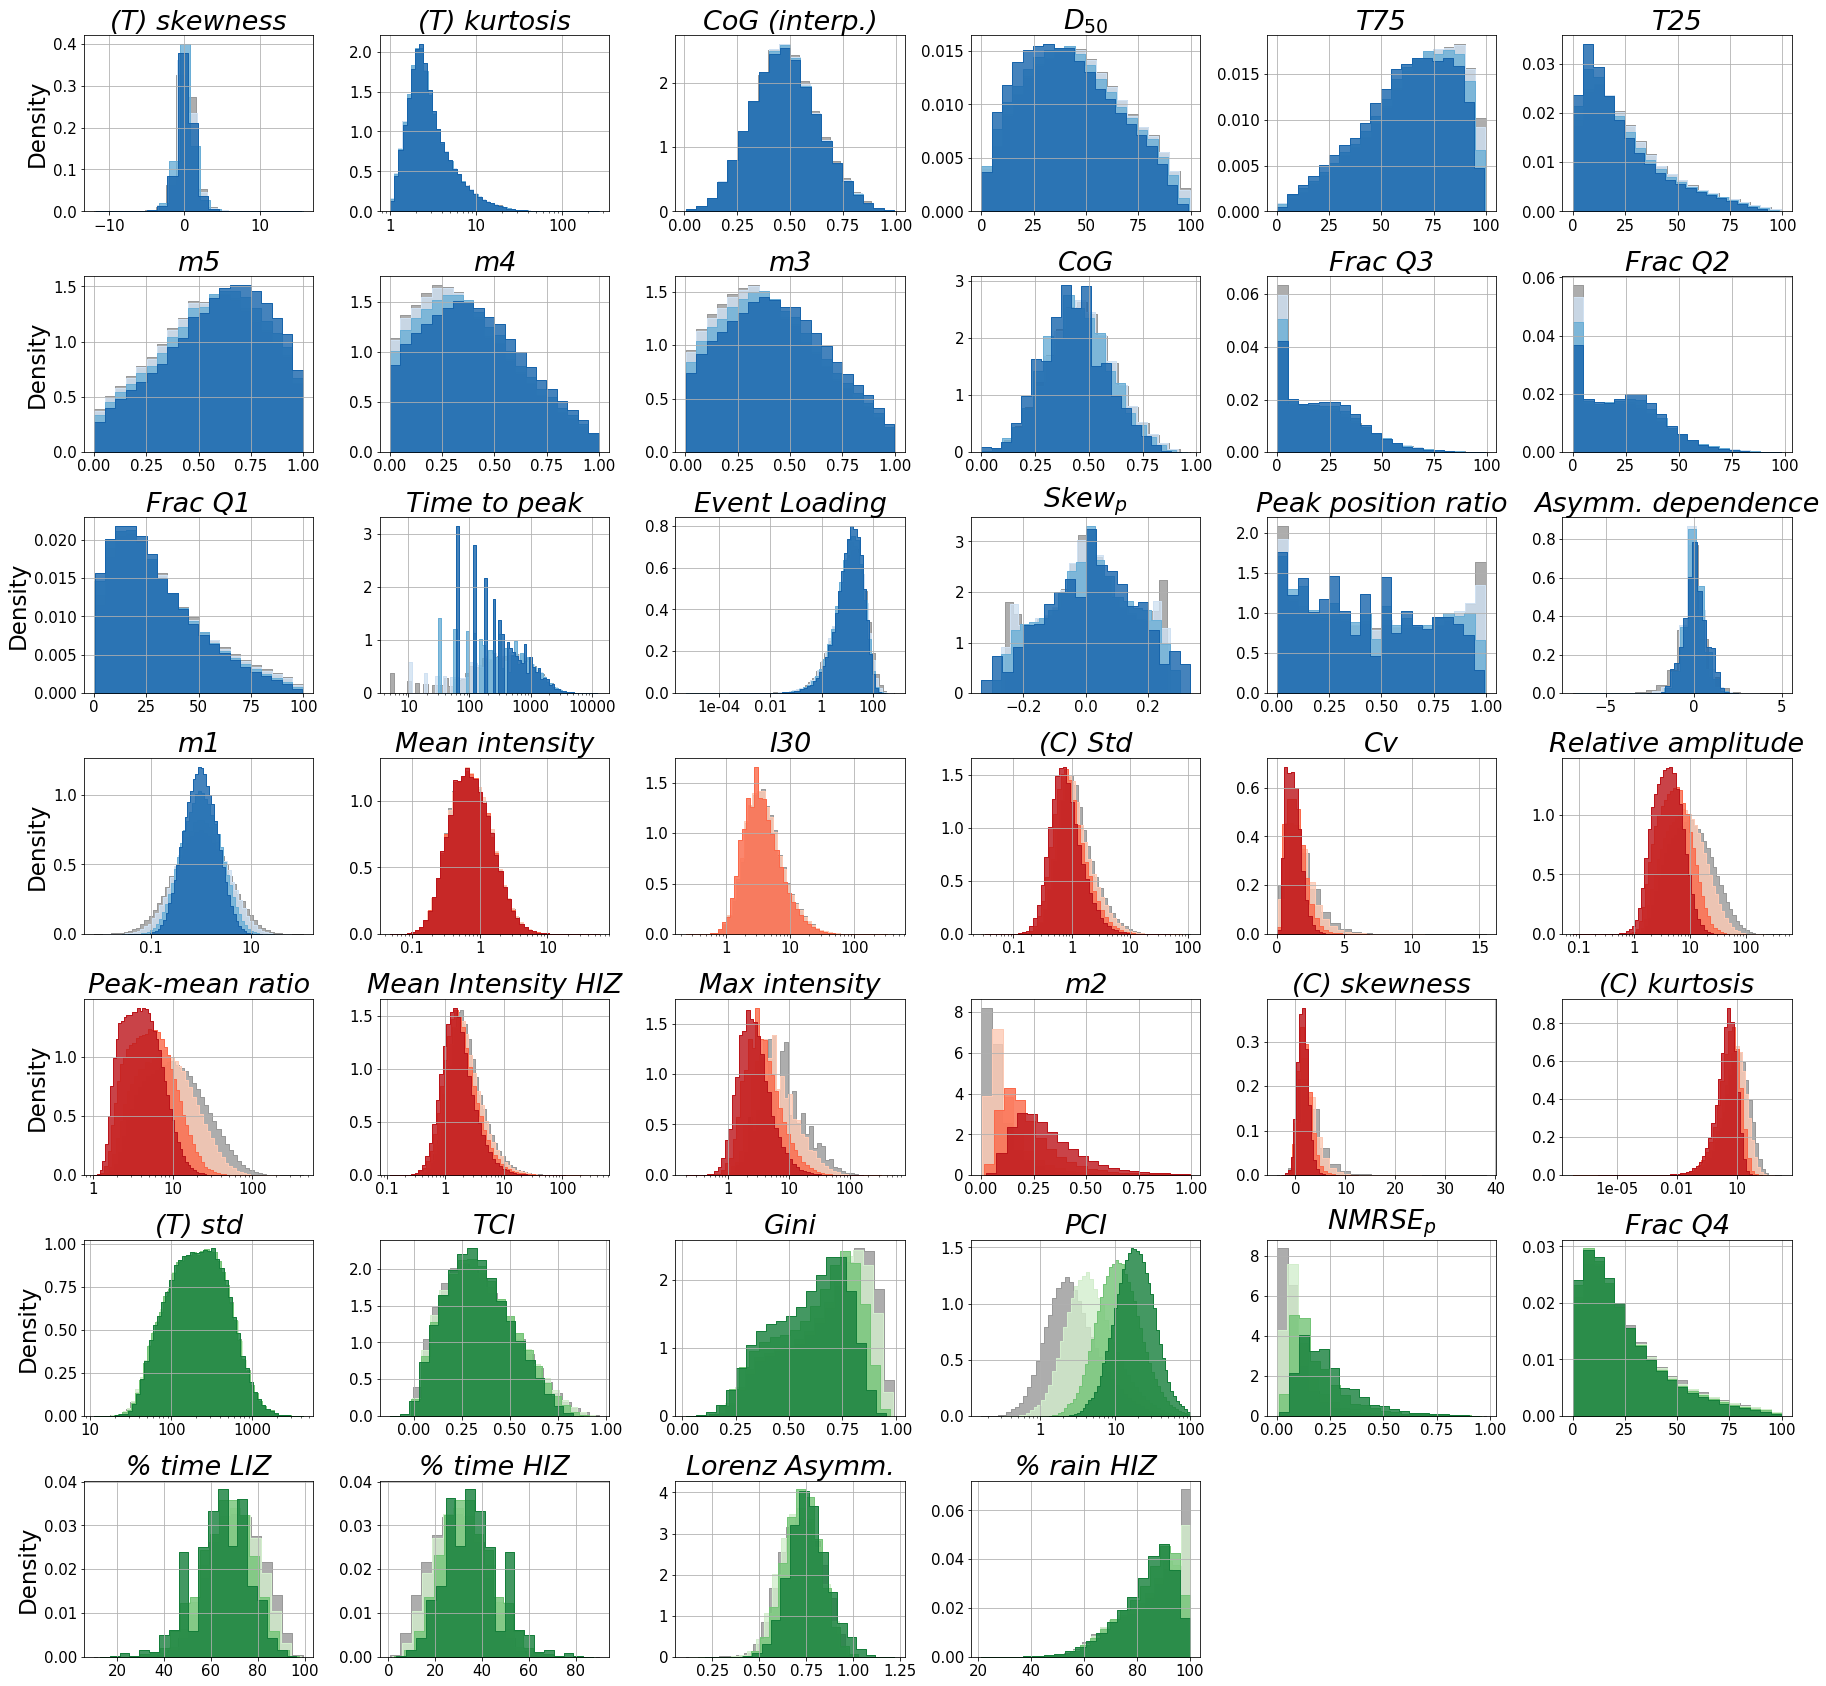

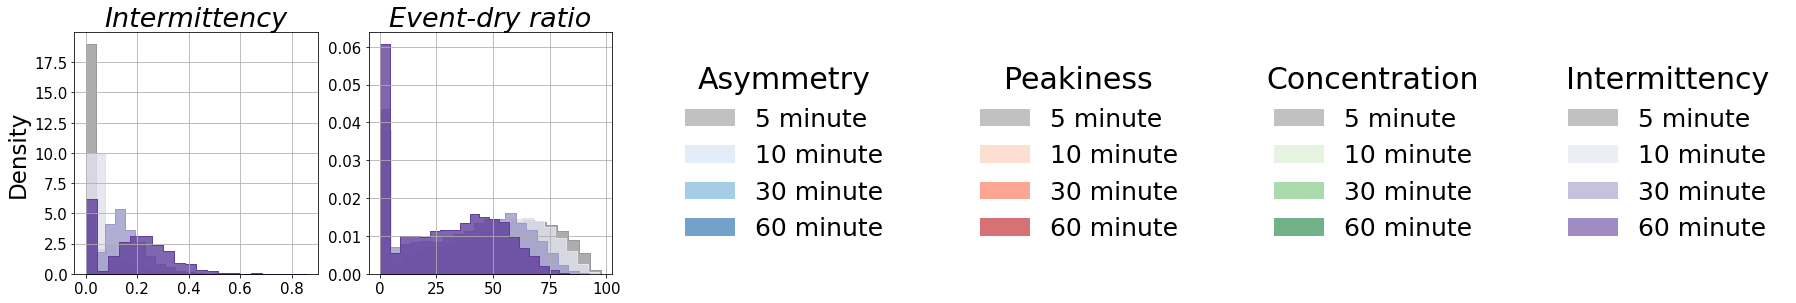

In [20]:
resolutions = ['_5m', '_10m', '_30m', '_60m']

log_x_metrics = ['m1', 'm1_wi', 'mean_intensity', 'max_intensity', 'time_kurtosis', 'time_to_peak', 'PCI',
                'kurtosis', 'Mean Intensity HIZ', 'I30', 'std', 'peak_mean_ratio', 'Event Loading', 'relative_amp',
                'time_std']

unique_metrics_main = df_other["metric"].unique()
n_cols_main = 6
n_rows_main = -(-len(unique_metrics_main) // n_cols_main)

fig_main, axs_main = plt.subplots(ncols=n_cols_main, nrows=n_rows_main,
                                  figsize=(4.2 * n_cols_main, 3.5 * n_rows_main),
                                  sharex=False, sharey=False)
axs_main = axs_main.flatten()

# Track max/min values for autoscaled limits
x_min, x_max, y_min, y_max = float('inf'), float('-inf'), float('inf'), float('-inf')

for i, this_metric in enumerate(unique_metrics_main):
    ax = axs_main[i]
    metric_data = df_other[df_other["metric"] == this_metric]
    plot_histograms(ax,transformed_minmax_scaled, this_metric, metric_data, log_x_metrics, type_color_map_1, resolutions)

    # Update global x/y limits
    x_vals = metric_data["rank_corr"]
    y_vals = metric_data["val_diff"]
    if not x_vals.empty and not y_vals.empty:
        x_min = min(x_min, x_vals.min())
        x_max = max(x_max, x_vals.max())
        y_min = min(y_min, y_vals.min())
        y_max = max(y_max, y_vals.max())

for ax in axs_main[len(unique_metrics_main):]:
    ax.axis('off')
    
for i, ax in enumerate(axs_main):
    if i % n_cols_main == 0:  # First column in each row
        ax.set_ylabel('Density', fontsize=23)
    else:
        ax.set_ylabel('')            
    
# fig_main.suptitle("Summary statistics (Asymmetry, Peakiness, Concentration)", fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

fig_main.savefig("../Figures/histograms_main.png", dpi=300, facecolor='white')

label_resolutions=['5 minute', "10 minute", "30 minute", "60 minute"]
# --- PLOT 2: Intermittency Figure ---
if not df_intermittency.empty:
    unique_metrics_int = df_intermittency["metric"].unique()
    n_cols_int = 6
    n_rows_int = -(-len(unique_metrics_int) // n_cols_int)

    fig_int, axs_int = plt.subplots(ncols=n_cols_int, nrows=n_rows_int,
                                    figsize=(4.2 * n_cols_int, 4.5 * n_rows_int),
                                    sharex=False, sharey=False)
    axs_int = axs_int.flatten()

    # Plot each metric
    for i, this_metric in enumerate(unique_metrics_int):
        ax = axs_int[i]
        metric_data = df_intermittency[df_intermittency["metric"] == this_metric]
        plot_histograms(ax, transformed_minmax_scaled, this_metric, metric_data, log_x_metrics, type_color_map_1, resolutions)

    legend_types = list(type_color_map_2.keys())
    legend_axes_start = len(unique_metrics_int)  # first free subplot

    for i, metric_type in enumerate(legend_types):
        idx = legend_axes_start + i
        if idx < len(axs_int):
            ax_legend = axs_int[idx]
            ax_legend.axis('off')
            colors = type_color_map_1[metric_type]
            patches = [Patch(facecolor=colors[j], label=label_resolutions[j], alpha=0.6) for j in range(len(resolutions))]
            ax_legend.legend(handles=patches, title=metric_type, loc='center', frameon=False, ncol=1, handlelength=2,
                             fontsize=25, title_fontsize =30)
            
    for i, ax in enumerate(axs_int):
        if i % n_cols_int == 0:  # First column in each row
            ax.set_ylabel('Density', fontsize=23)
        else:
            ax.set_ylabel('')            

    # Turn off any remaining unused axes after legend
    for ax in axs_int[legend_axes_start + len(legend_types):]:
        ax.axis('off')

#     fig_int.suptitle("Intermittency metrics", fontsize=25)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    fig_int.savefig("../Figures/histograms_intermittency.png", dpi=300, facecolor='white')

### Categorical metrics

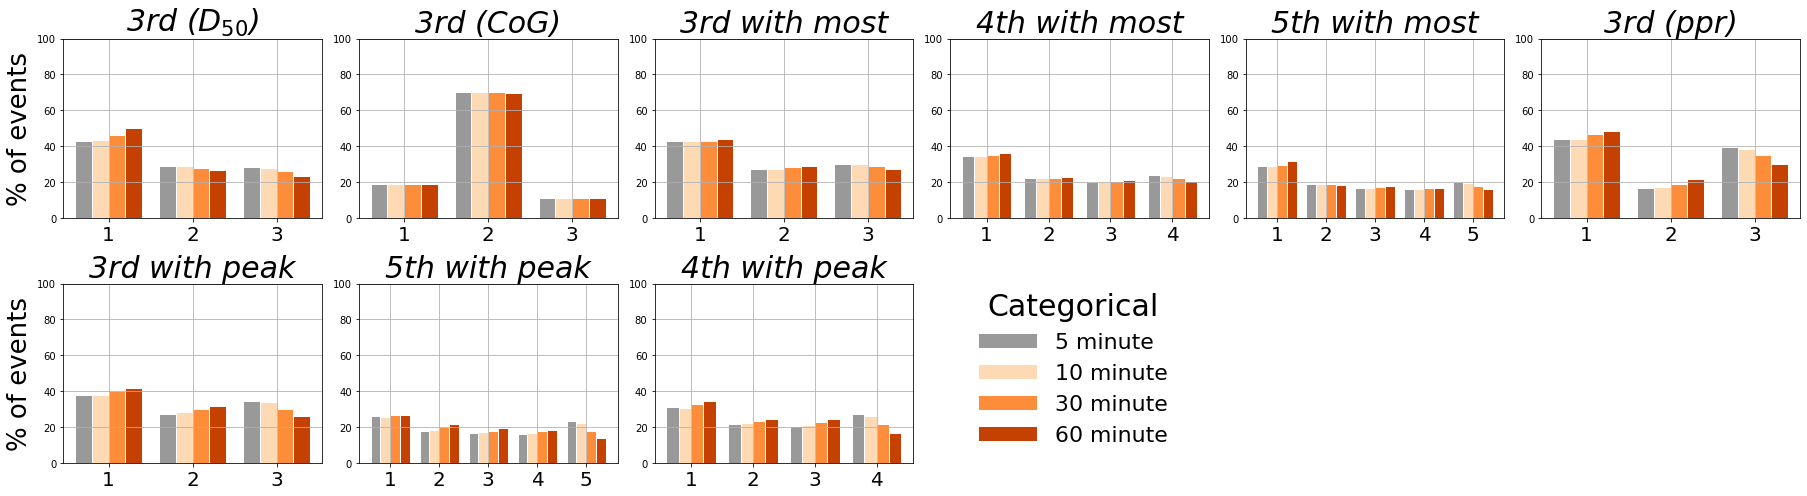

In [27]:
# --- now make your grid of small multiples ---
unique_metrics =df_categorical['metric'].unique().tolist()
n_cols = 6
n_rows = -(-len(unique_metrics) // n_cols)
fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(4.2 * n_cols, 3.5 * n_rows), sharex=False, sharey=False)
axs = axs.flatten()

for i, metric in enumerate(unique_metrics):
    plot_grouped_categorical(
        axs[i],
        metric,
        transformed_minmax_scaled,
        type_color_map_2, resolutions)

# turn off any unused axes
for ax in axs[len(unique_metrics):]:
    ax.axis('off')

for i, ax in enumerate(axs):
    if i % n_cols == 0:  # First column in each row
        ax.set_ylabel('% of events', fontsize=26)
    else:
        ax.set_ylabel('')    
    
# Create custom legend handles using the palette
palette = type_color_map_1['Categorical']
legend_handles = [Patch(facecolor=palette[i], edgecolor='white', label=res, alpha=1)
    for i, res in enumerate(resolutions)]

fig.legend(handles=legend_handles,
    labels=label_resolutions,
    title="Categorical",
     frameon=False,
    title_fontsize=30,    # larger title
    fontsize=22,          # larger labels
    bbox_to_anchor=(0.53, 0.26),
    loc='center left',
    labelspacing=0.5,     # space between labels
    handlelength=2.7,     # length of color boxes
    handletextpad=0.8)

# fig.suptitle("../Figures/Categorical metrics", fontsize=25)
plt.tight_layout()
plt.show()
fig.savefig("../Figures/grouped_categorical_metrics.png", dpi=300, facecolor='white')